# Machine learning the mechanical properites of bulk materials

<font color=#000000 size=3 face="黑体"> Author: Xu Lei  <p>   </p>  Email: xulei0553@gmail.com</font>

#  Prerequisites

## The following packages should be installed in advance:
## 1. scikit-learn, 2. pymatgen

# 0. Propose

## There are two main things you will learn in this tutorial. The first one is to know how to query data from material project database. Another one is to use the data retrieved from database to do some machine learning study.

# 1. Data retrieval

## The most impost task in this part is to learn how to retrive specified data from "Material Project" database. In the following, we show how to query material's elasticity property from the database.

### First, go to https://materialsproject.org and register an account with your email. Then, login to https://www.materialsproject.org/dashboard to get your own API key.

### Import relevant packages and show the supported properties for query

In [1]:
from pymatgen import Structure
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure


#list the features which can retrieve from material project database
with MPRester() as mpr:
    print(mpr.supported_properties)

('energy', 'energy_per_atom', 'volume', 'formation_energy_per_atom', 'nsites', 'unit_cell_formula', 'pretty_formula', 'is_hubbard', 'elements', 'nelements', 'e_above_hull', 'hubbards', 'is_compatible', 'spacegroup', 'task_ids', 'band_gap', 'density', 'icsd_id', 'icsd_ids', 'cif', 'total_magnetization', 'material_id', 'oxide_type', 'tags', 'elasticity')


### Connect to the database with API key, and then retrieve specified features from the database for all materials (!!!!!Noted that you need to use your own API key when initialize the MPRester(  )). Please refer to https://github.com/materialsproject/mapidoc/blob/master/example_notebooks/Using%20the%20Materials%20API%20with%20Python.ipynb for more details about query 

In [2]:
#Replace the string in the bracket with your own API key
mpr = MPRester('place your own API key here')
#Request "material_id", "elasticity" and "cif" information for all materials in the database
st=mpr.query(criteria={},properties=["material_id","elasticity","cif"])

### There are 120612 materials in the material project database, but only 13619 of them have elasticity properties. Below is an example to show what kinds of elasticity properties included in the database. (Please refer to https://wiki.materialsproject.org/Elasticity_calculations for more details about these calculated properties)

In [3]:
i=0
for item in st:
    if item["elasticity"]:
        print(item['elasticity'])
        break        

### Write all elasticity properties together with material_id and structure into a dataframe, and then save it to a csv file

In [4]:
import pandas as pd

cols=["material_id","structure","G_Reuss","G_VRH","G_Voigt","G_Voigt_Reuss_Hill","K_Reuss","K_VRH","K_Voigt","K_Voigt_Reuss_Hill","elastic_anisotropy","homogeneous_poisson","poisson_ratio","universal_anisotropy"]
df=pd.DataFrame(columns=cols)
i=1
for item in st:
    if item["elasticity"]:
        df.loc[i,"material_id"]=item["material_id"]
        df.loc[i,"structure"]=Structure.from_str(item["cif"],fmt="cif")
        df.loc[i,"G_Reuss"]=item["elasticity"]["G_Reuss"]
        df.loc[i,"G_VRH"]=item["elasticity"]["G_VRH"]
        df.loc[i,"G_Voigt"]=item["elasticity"]["G_Voigt"]
        df.loc[i,"G_Voigt_Reuss_Hill"]=item["elasticity"]["G_Voigt_Reuss_Hill"]
        df.loc[i,"K_Reuss"]=item["elasticity"]["K_Reuss"]
        df.loc[i,"K_VRH"]=item["elasticity"]["K_VRH"]
        df.loc[i,"K_Voigt"]=item["elasticity"]["K_Voigt"]
        df.loc[i,"K_Voigt_Reuss_Hill"]=item["elasticity"]["K_Voigt_Reuss_Hill"]
        df.loc[i,"elastic_anisotropy"]=item["elasticity"]["elastic_anisotropy"]
        df.loc[i,"homogeneous_poisson"]=item["elasticity"]["homogeneous_poisson"]
        df.loc[i,"poisson_ratio"]=item["elasticity"]["poisson_ratio"]
        df.loc[i,"universal_anisotropy"]=item["elasticity"]["universal_anisotropy"]
        i+=1

df.to_csv("material_project_elasticity.csv",index=False)

# 2. Data visualization

## In this tutorial, G_VRH, which is Shear modulus, is selected as an example to show how to use machine learning to predict elasticity property. Below is the distribution of G_VRH data.

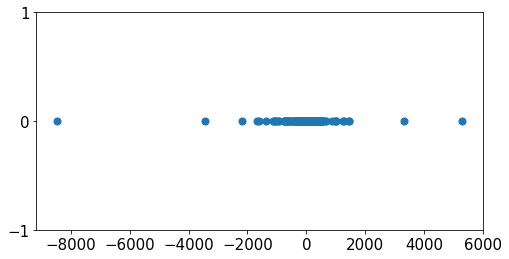

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df=pd.read_csv("material_project_elasticity.csv")
G_VRH_data=df["G_VRH"].values

y0=np.zeros((len(G_VRH_data),))
plt.figure(figsize=(8,4))
plt.scatter(G_VRH_data,y0,s=50)
plt.xticks(fontsize=15)
plt.yticks([-1,0,1],fontsize=15)
plt.show()

# 3. Feature extraction

## For each 2D material, use Matminer package to exctact 271 VT based features (refer to "Phys. Rev. B 96, 024104" for more details), and store the features into a dataframe named feature_data. At last, save the feature data in a csv file.

In [6]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.structure import (SiteStatsFingerprint, StructuralHeterogeneity, ChemicalOrdering, StructureComposition, MaximumPackingEfficiency)
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital, IonProperty
from matminer.featurizers.site import CoordinationNumber,LocalPropertyDifference
from matminer.utils.data import MagpieData

element_properties=('Electronegativity','Row','Column','Number','MendeleevNumber','AtomicWeight','CovalentRadius','MeltingT',
         'NsValence','NpValence','NdValence','NfValence','NValence','NsUnfilled','NpUnfilled','NdUnfilled','NfUnfilled',
         'NUnfilled','GSvolume_pa','SpaceGroupNumber','GSbandgap','GSmagmom')

#The following features will be created by using matminer package.
featurizer = MultipleFeaturizer([
    SiteStatsFingerprint(CoordinationNumber().from_preset('VoronoiNN'),stats=('mean','std_dev','minimum','maximum')),
    StructuralHeterogeneity(),
    ChemicalOrdering(),
    MaximumPackingEfficiency(),
    SiteStatsFingerprint(LocalPropertyDifference(properties=element_properties),stats=('mean','std_dev','minimum','maximum','range')),
    StructureComposition(Stoichiometry()),
    StructureComposition(ElementProperty.from_preset("magpie")),
    StructureComposition(ValenceOrbital(props=['frac'])),
    StructureComposition(IonProperty(fast=True))    
])

#read data from csv file
df=pd.read_csv("material_project_elasticity.csv")
#Generate VT based features from the material's crystal structure.
feature_data=featurizer.featurize_dataframe(df,col_id=['structure'],ignore_errors=True)
#"structure", "compound possible" and "material_id" are not resonable physical features, so we drop these three columns
feature_data=feature_data.drop(["structure","compound possible","material_id"],axis=1)
#write the data into a csv file for later use
feature_data.to_csv("material_project_elasticity_data.csv",index=False)

# 4. Data clearning

## There are many missing values in the features generated by VT method, and we use the mean value to fill these missing points. On the other hand, from the data distribution figure of G_VRH, we can find that most data fall on [-300,400] and only 57 points out of it. Thus, these 57 data are regarded as outliers and exclued in the following discussion.

In [7]:
import pandas as pd
import numpy as np

#read data from csv file
data_df=pd.read_csv("material_project_elasticity_data.csv")
#fill the NaN with the mean value of the corresponding column
data_df=data_df.fillna(data_df.mean())
#remain data with G_VRH value in [-2000,2000].
data_df=data_df[data_df["G_VRH"]<=400]
data_df=data_df[data_df["G_VRH"]>=-300]

# 5. Machine learning model

## In this tutorial, use Gradient Boosting algorithm as an example to show how to build and run a machine learning model.

### Import relevant packages

In [8]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import train_test_split,KFold,ShuffleSplit
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Assign features and labels to x and y, respectively. Then, split the data into train and test set.

In [9]:
y=data_df["G_VRH"].values
del_cols=["G_Reuss","G_VRH","poisson_ratio","G_Voigt","G_Voigt_Reuss_Hill","K_Reuss","K_VRH","K_Voigt","K_Voigt_Reuss_Hill","elastic_anisotropy","homogeneous_poisson","poisson_ratio","universal_anisotropy"]
X=data_df.drop(del_cols,axis=1).values
#75% of data is used for training, the rest is for testing.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

### Build a Gradient Boosting regressor model, and tune some model parameters, such as n_estimators and max_depth, to achieve a high score, which corresponds to an optimized model. (Noted that the parameter in the below may not be the optimal one, you can change them by yourself)

In [10]:
lr=GradientBoostingRegressor(n_estimators=500,random_state=1,max_depth=5)
#use 5-fold cross-validation approach to find the best model parameters
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=1)
scores=cross_val_score(lr,X_train,y_train,cv=cv,scoring="neg_mean_absolute_error")
print("scores:  ",str(-np.mean(scores)))

scores:   16.287471086102144


### Traning the optimized model with train data, and then do the prediction for the test set and calculate the mean absolute error

In [11]:
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
#calculate and print test error
print("MAE:  ",np.mean(abs(y_pred-y_test)))

MAE:   15.31740782139745


# 6. Result analysis

## Visualize the prediction result

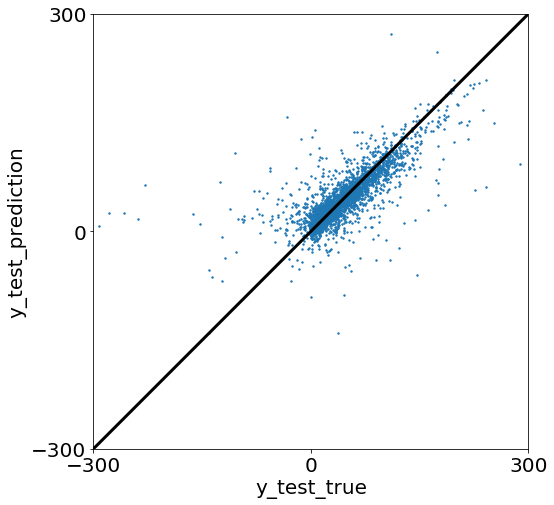

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

t=300
x1=np.linspace(-t,t,100)
plt.figure(figsize=(8,8))
plt.scatter(y_test,y_pred, s=2)
plt.xlim([-t,t])
plt.ylim([-t,t])
plt.xticks([-t,0,t],fontsize=20)
plt.yticks([-t,0,t],fontsize=20)
plt.xlabel("y_test_true",fontsize=20)
plt.ylabel("y_test_prediction",fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(x1,x1,c='k',lw=3)
plt.show()

## Find the five most important features and plot the relative importance

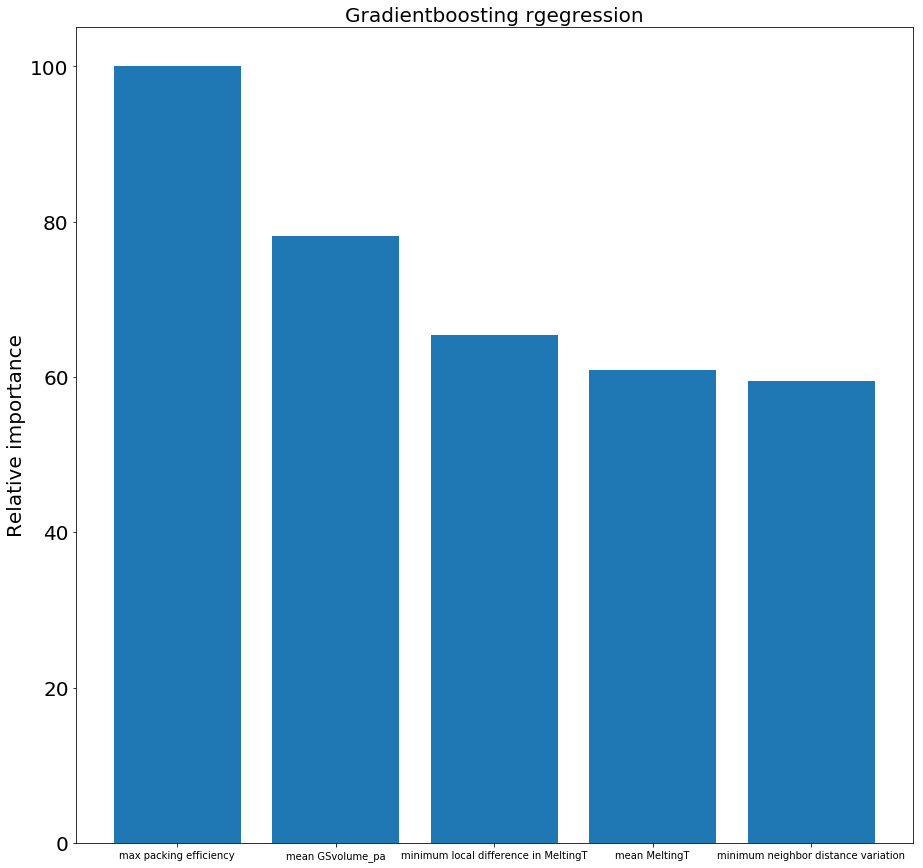

In [13]:
#Define a function to plot the relative feature importance
def plot_feature_importances(feature_importances,title,feature_names):
    feature_importances=100.0*(feature_importances/max(feature_importances))
    index_sorted=np.flipud(np.argsort(feature_importances))[:5]
    pos=np.arange(index_sorted.shape[0])+0.5


    plt.figure(figsize=(15,15))
    plt.bar(pos,feature_importances[index_sorted],align="center")
    plt.xticks(pos,feature_names[index_sorted],fontsize=10)
    plt.yticks([0,20,40,60,80,100],fontsize=20)
    plt.ylabel("Relative importance",fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

#Sort the feature importance in descending order and call plot_feature_importance function to plot them.
features=data_df.drop(del_cols,axis=1).columns.values
importances=lr.feature_importances_
indices = np.argsort(importances)[::-1]
plot_feature_importances(importances,"Gradientboosting rgegression",features)
